# Analysis of Graphs
This file contains analysis and visualizations of the graphs created in do_create_graph.py.

In [3]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np
from matplotlib.patches import FancyArrowPatch

from graph_helpers import *

In [ ]:
def get_split_index(y):
    rng = np.random.RandomState(42)  # For reproducibility
    N = len(y)
    indices = np.arange(N)

    val_size = config.data_settings.validation_ratio
    test_size = config.data_settings.test_ratio
    sample_window = config.data_settings.sample_window
    test_val_size = int(N * (val_size + test_size))

    valid_rows = ~np.isnan(y).any(axis=1)
    valid_indices = np.where(valid_rows)[0]

    if len(valid_indices) < test_val_size:
        raise ValueError(f"Not enough valid samples. Needed: {test_val_size}, Available: {len(valid_indices)}")

    collected = set()
    attempts = 0
    max_attempts = 50000  

    while len(collected) < test_val_size and attempts < max_attempts:
        start_idx = rng.choice(valid_indices)
        following_valid = valid_indices[valid_indices >= start_idx]
        window = following_valid[:sample_window]
        collected.update(window)
        attempts += 1

    collected = list(collected)
    if len(collected) < test_val_size:
        raise ValueError(f"Only {len(collected)} valid indices collected after resampling, but {test_val_size} required.")

    selected_indices = collected[:test_val_size]
    val_end = int(len(selected_indices) * val_size / (val_size + test_size))

    val_indices = np.array(list(selected_indices[:val_end]))
    test_indices = np.array(list(selected_indices[val_end:]))

    train_indices = np.setdiff1d(indices, selected_indices)
    rng.shuffle(train_indices)

    return train_indices, val_indices, test_indices

In [73]:
y = np.arange(10000).reshape(-1,1)
get_split_index(y)

(array([1169, 6098,  115, ..., 2885, 6076,  643], shape=(8000,)),
 array([   1, 8194, 8195,    4,    5,    9, 8202,   11,   13, 8208,   16,
        8212, 8213,   21, 8219, 8220, 8226, 8227, 8228, 8230,   38, 8232,
        8234, 8238, 8245,   54,   55,   60,   64, 8258,   72, 8264,   74,
          77,   78,   89,   94, 8286,   98,  105, 8306, 8308,  117,  116,
        8311,  125,  126, 8319, 8320, 8321, 8322,  130,  133, 8325,  137,
         140, 8335,  145, 8338,  147, 8340,  148,  153,  154,  158, 8352,
         161,  163, 8356, 8357, 8363, 8378,  189,  190,  197, 8389, 8392,
        8393,  202,  206,  207,  213, 8407, 8415,  224,  225,  232, 8427,
         235, 8428,  236, 8429, 8433, 8434, 8435, 8436,  249, 8442, 8445,
         255,  260, 8453,  262,  269,  271, 8465, 8467,  277, 8472,  281,
        8476, 8477,  285,  294,  301,  302,  306, 8502, 8503, 8508,  317,
        8512, 8519,  329, 8527, 8529,  338,  340, 8533,  341,  345,  352,
        8549, 8551, 8554,  362,  364, 8555,  3

In [388]:
train_file_path = '/Users/lisavind/GitHub/wind_power_prediction/data/graphs/directed_True_simulated_True_local_False_global_True_features_4_D_136_length_2720_width_2_angle_3/train.pt'


In [389]:
windFarmCoord = pd.read_csv('../../data/coordinates_kronoberg.csv')
print('Read data successfully')

x_pos, y_pos, z_pos = windFarmCoord[['X (m)','Y (m)','Z (m)']].to_numpy().T

Read data successfully


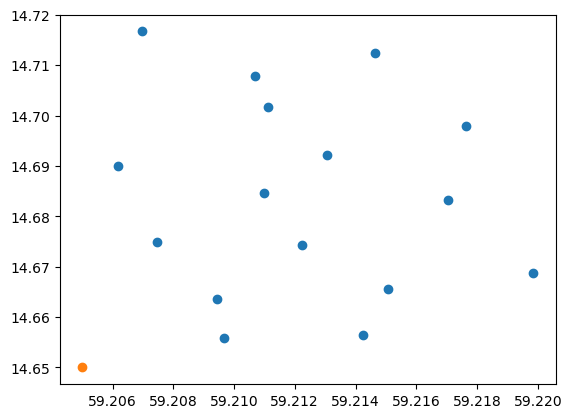

In [390]:
plt.scatter(windFarmCoord['Latitude'],windFarmCoord['Longitude'])
plt.scatter(59.205,14.65)


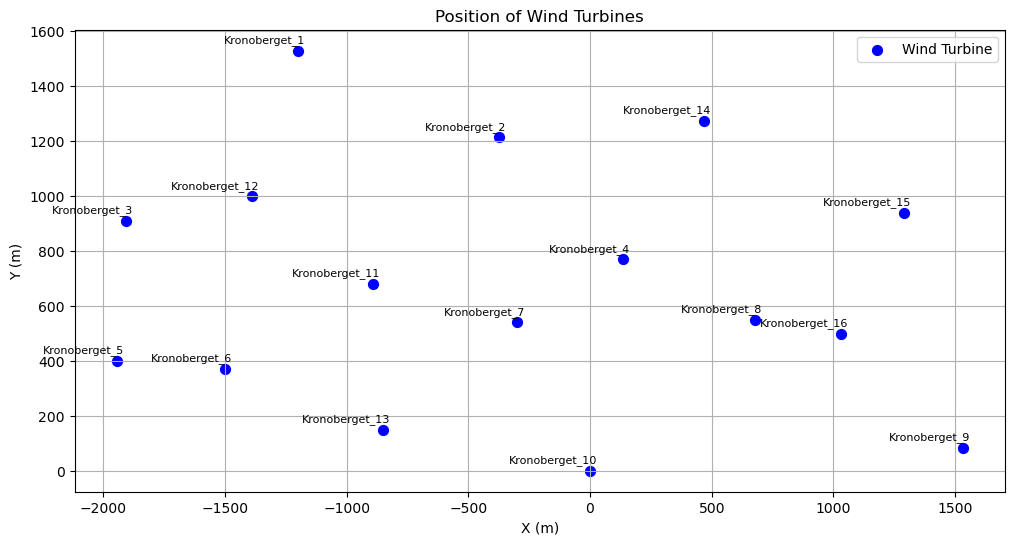

In [391]:
plt.figure(figsize=(12, 6))
plt.scatter(x_pos, y_pos, color='blue', s=50, label='Wind Turbine')
offset_label = 30
# Add annotations for turbine numbers
for i, row in windFarmCoord.iterrows():
    plt.text(row["X (m)"]+ offset_label, row["Y (m)"]+offset_label, f"{row['Wind Turbine No.']}", fontsize=8, ha='right')

# Set plot labels and title
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Position of Wind Turbines")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [392]:
graphs_train = torch.load(train_file_path, weights_only=False)

In [393]:
torch.manual_seed(10)
train_loader = DataLoader(graphs_train, batch_size=1, shuffle=True,
                              exclude_keys=[], num_workers=0, pin_memory=True)

In [394]:
x_pos

array([-1197.98709  ,  -374.0119107, -1905.967915 ,   133.9865108,
       -1942.976778 , -1499.988555 ,  -298.0137241,   676.006767 ,
        1530.022521 ,     0.       ,  -889.9894644, -1386.975916 ,
        -850.9990706,   468.0113717,  1287.978809 ,  1031.008371 ])

In [395]:
y_pos

array([1528.998276  , 1213.977835  ,  909.9870152 ,  768.9593547 ,
        398.9413305 ,  371.9602201 ,  539.9141179 ,  550.020799  ,
         82.94649066,    0.        ,  678.9475984 ,  998.9950777 ,
        149.9277825 , 1273.990098  ,  938.970704  ,  499.0076604 ])

In [396]:
coordinates = np.array([x_pos, y_pos]).T

In [397]:
test_array = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
])

In [398]:
edge_index_test = convert_adjacency_matrix_to_edge_index(test_array)

In [399]:
print(edge_index_test)

tensor([[ 1,  2,  2,  3,  4,  4,  4,  5,  5,  5,  6,  6,  7,  9, 10, 10, 10, 10,
         10, 11, 11, 12, 12],
        [13,  3, 11, 14,  5,  6,  7,  6,  7, 15,  7, 15, 15,  8,  3,  6,  7, 14,
         15,  3, 14,  8,  9]])


## Analysis of graph
This section is an analysis of the directed graph. The node connections compared to the wind direction and the edge attributes. The edge attributes are distance and relative angle between nodes and wind direction. We want the relative angle to be a value between 0 and 1 where 1 means vectors are aligned and 0 means they are not aligned. The distance is scaled using the maximum distance so the values range between 0 and 1.

In [400]:
#Loading in example data point
for data in train_loader:
    x = data.x
    edge_index = data.edge_index
    edge_attribute = data.edge_attr
    batch = data.batch
    break

In [401]:
def get_vector_wind_speed(angle):
    rad = np.radians(-angle)

    x1 = 0
    y1 = -1

    x2 = x1*np.cos(rad) - y1*np.sin(rad)
    y2 = x1*np.sin(rad) + y1*np.cos(rad)

    norm = np.linalg.norm((x2,y2))

    x2 = x2/norm* 750
    y2 = y2/norm* 750
    
    return x1,y1,x2, y2


def get_vector_bearing(angle):
    rad = np.radians(-angle)

    x1 = 0
    y1 = 1

    x2 = x1*np.cos(rad) - y1*np.sin(rad)
    y2 = x1*np.sin(rad) + y1*np.cos(rad)

    norm = np.linalg.norm((x2,y2))

    x2 = x2/norm* 750
    y2 = y2/norm* 750

    return x1,y1,x2,y2


In [402]:
def plot_relative_angle(wd,src, dst):

    src_pos = coordinates[src]
    dst_pos = coordinates[dst]#-np.array([1500,200])
    #print('Source position',src_pos)
    #print('Destination position',dst_pos)
   
    dx = dst_pos[0] - src_pos[0]
    dy = dst_pos[1] - src_pos[1]

    _,_,xwd,ywd = get_vector_wind_speed(wd)

    print('Angle vector between nodes' ,np.degrees(np.arctan2(dy, dx)))
    print('Angle wind direction vector', np.degrees(np.arctan2(ywd, xwd)))

    bearing = (np.degrees(np.arctan2(dx, dy)) + 360) % 360
    print('Bearing',bearing)

    wd_actual = (wd + 180) % 360
    print('Wind direction flipped', wd_actual)

    _,_,xb,yb = get_vector_bearing(bearing)

    angle = np.degrees(np.arctan2(dy, dx) - np.arctan2(ywd, xwd))

    angle_diff_right = (wd_actual - bearing + 360) % 360
    angle_diff_left = (bearing - wd_actual + 360) % 360

    print('Angle difference right', angle_diff_right)
    print('Angle difference left', angle_diff_left)

    angle_diff = np.min((angle_diff_right,angle_diff_left))

    angle_diff_scaled = 1 - angle_diff/180
    print('Angle difference scaled', angle_diff_scaled)

    G = nx.DiGraph()
    
    G.add_node(src, pos=(src_pos))
    G.add_node(dst, pos=(dst_pos))

    pos = nx.get_node_attributes(G, 'pos')

    plt.figure(figsize=(12, 6))
    pathcollection = nx.draw_networkx_nodes(G, pos)   
    edge_labels = {(node1, node2): f"{G[node1][node2]['angle']:.2f}" for node1, node2 in G.edges()}
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='red')
    plt.grid()
    plt.colorbar(pathcollection)
    arrow1 = FancyArrowPatch((src_pos),(src_pos + (xwd,ywd)),mutation_scale=15,color='blue',arrowstyle='->', linewidth=2)
    arrow2 = FancyArrowPatch((src_pos),(src_pos + (dx,dy)),mutation_scale=15,color='red',arrowstyle='->', linewidth=2)
    arrow3 = FancyArrowPatch((src_pos),(src_pos + (xb,yb)),mutation_scale=15,color='black',arrowstyle='->', linewidth=2)
    plt.gca().add_patch(arrow1)
    plt.gca().add_patch(arrow2)
    plt.gca().add_patch(arrow3)
    plt.title('Graph Visualization')
    plt.xlim(-1500,1500)
    plt.ylim(-1500,1500)
    plt.show()


Angle vector between nodes 3.1031152218063287
Angle wind direction vector -90.0
Bearing 86.89688477819368
Wind direction flipped 180
Angle difference right 93.10311522180632
Angle difference left 266.8968847781937
Angle difference scaled 0.4827604709899649


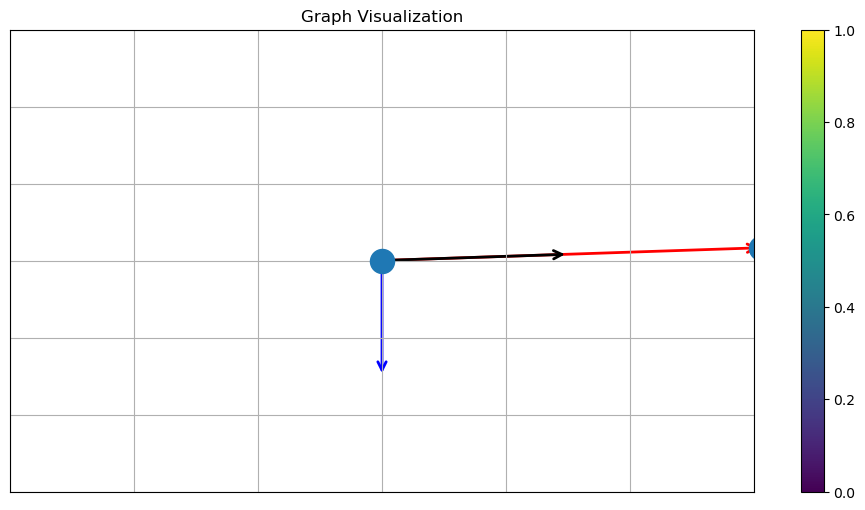

In [403]:
plot_relative_angle(0,9, 8)

In [404]:
#Note: This can most likely be written more effectively??
def compute_relative_angle(edge_index, coordinates, wd):
    angles = []

    for src, dst in zip(edge_index[0], edge_index[1]):
        src, dst = src.item(), dst.item() 
        
        src_pos = coordinates[src]
        dst_pos = coordinates[dst]
 
        dx = dst_pos[0] - src_pos[0]
        dy = dst_pos[1] - src_pos[1]
 
        # Compute the bearing of the line from Node 1 to Node 2
        # Using np.arctan2(dx, dy) so 0° is north, angles increase clockwise.
        bearing = (np.degrees(np.arctan2(dx, dy)) + 360) % 360
 
        # Example: wind "from" 45° => actual wind direction is 45 + 180 = 225
        wd_actual = (wd + 180) % 360

        angle_diff_right = (wd_actual - bearing + 360) % 360
        angle_diff_left = (bearing - wd_actual + 360) % 360

        angle_diff = np.min((angle_diff_right,angle_diff_left))

        angle_diff_scaled = 1 - angle_diff/180
 
        angles.append(angle_diff_scaled)

    angles = np.array(angles)
    if angles.T.ndim == 1:
        angles = angles[:, np.newaxis]
 
    return angles

In [405]:
angles = compute_relative_angle(edge_index, coordinates, 315)

In [406]:
x

tensor([[0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481],
        [0.1812, 0.0153, 0.9977, 0.5481]])

In [407]:
edge_index

tensor([[ 0,  0,  1,  2,  3, 10, 11],
        [ 5, 11,  6,  4,  9, 12,  5]])

In [408]:
edge_attribute

tensor([[0.3384, 0.1074, 0.9937, 0.5792],
        [0.1592, 0.1695, 0.9849, 0.6219],
        [0.1919, 0.1790, 0.9892, 0.3964],
        [0.1450, 0.3007, 0.9999, 0.4880],
        [0.2209, 0.5800, 0.9986, 0.5380],
        [0.1501, 0.5609, 0.9928, 0.4155],
        [0.1803, 0.0621, 0.9983, 0.5409]])

In [409]:
edge_index[0,:]

tensor([ 0,  0,  1,  2,  3, 10, 11])

In [410]:
def inverse_transform_wind_direction(sin_val, cos_val):
    """
    Converts sine and cosine components back to wind direction in degrees.
    
    Parameters:
    - sin_val (pd.Series or np.array): Sine of wind direction.
    - cos_val (pd.Series or np.array): Cosine of wind direction.

    Returns:
    - degrees (pd.Series or np.array): Wind direction in degrees (0 to 360).
    """
    radians = np.arctan2(sin_val, cos_val)
    degrees = np.rad2deg(radians)
    degrees = (degrees + 360) % 360  # Ensure degrees are in [0, 360)
    return degrees

In [411]:
x[0]

tensor([0.1812, 0.0153, 0.9977, 0.5481])

In [412]:
angle_wd = x[:,1].numpy() * 360#(360 - 0.01) - 0.01
print(angle_wd[0])

5.5101533


In [413]:
cos_val = x[0, 2] * 2 - 1
sin_val = x[0, 3] * 2 - 1

degrees = inverse_transform_wind_direction(sin_val, cos_val)
print(degrees)

tensor(5.5200)


In [414]:
ei = torch.where(edge_index[0,:] == 3)[0].numpy()

In [415]:
def plot_directed_graph_node(node_index):
    #Plot for one node!
    ei = torch.where(edge_index[0,:] == node_index)[0].numpy()

    G = nx.DiGraph()

    for i in range(x.shape[0]):
        j = i%16
        G.add_node(i, pos=(x_pos[j], y_pos[j]))

    for i in ei:
        node1 = edge_index[0, i].item()
        node2 = edge_index[1, i].item()
        G.add_edge(node1,node2)
        sin_val = edge_attribute[i, -1].item() * 2 - 1
        cos_val = edge_attribute[i, -2].item() * 2 - 1
        angle_node = inverse_transform_wind_direction(sin_val, cos_val)
        G[node1][node2]["angle"] = angle_node
        G[node1][node2]["distance"] = edge_attribute[i, 0].item()

    pos = nx.get_node_attributes(G, 'pos')

    node_colors = x[:,0].numpy()
    #sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))

    node_size = x[:,0].numpy() * 100

    angle_wd = x[:,1].numpy() * 360
    print(angle_wd)

    cos_val = x[0, 2] * 2 - 1
    sin_val = x[0, 3] * 2 - 1

    degrees = inverse_transform_wind_direction(sin_val, cos_val)

    x1,y1,x2,y2 = get_vector_wind_speed(degrees)

    plt.figure(figsize=(12, 6))  # Set the size of the plot
    print(G.edges())

    pathcollection = nx.draw_networkx_nodes(G, pos, node_color=node_colors,node_size=node_size)   
    edge_labels = {(node1, node2): f"{G[node1][node2]['angle']:.2f}" for node1, node2 in G.edges()}
    print(edge_labels)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='red')
    plt.axis('on')
    plt.grid()
    plt.colorbar(pathcollection)
    arrow = FancyArrowPatch((coordinates[node_index,0],coordinates[node_index,1]),(coordinates[node_index,0] + x2,coordinates[node_index,1]+ y2),mutation_scale=15,color='blue',arrowstyle='->', linewidth=2)
    plt.title('Graph Visualization')
    plt.gca().add_patch(arrow)
    plt.show()

[5.5101533 5.5101533 5.5101533 5.5101533 5.5101533 5.5101533 5.5101533
 5.5101533 5.5101533 5.5101533 5.5101533 5.5101533 5.5101533 5.5101533
 5.5101533 5.5101533]
[(10, 12)]
{(10, 12): '350.26'}


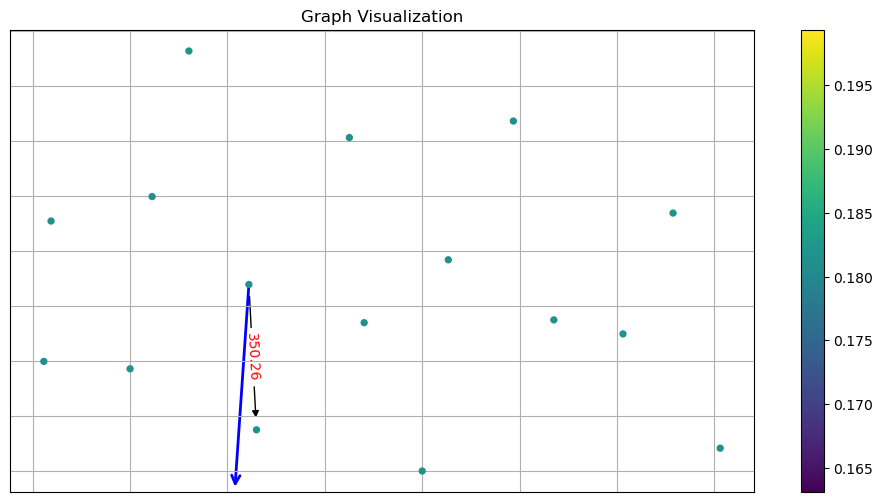

In [416]:
plot_directed_graph_node(10)

### For all graphs analyse if we have isolated nodes
Save and create a histogram

In [186]:
print(len(train_loader))

5040


In [182]:
number_edges = []
number_isolated_nodes = []

node_numbers = {0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15}

for data in train_loader:
    x = data.x
    edge_index = data.edge_index.numpy()
    edge_attribute = data.edge_attr


    sources = set(edge_index[0, :]) #edge_index[0, :]
    targets = set(edge_index[1, :])

    nodes_graph = set.union(sources,targets)
    #print(nodes_graph)
    #print(len(nodes_graph))

    number_isolated_nodes.append(16-len(nodes_graph))

    number_edges.append(edge_index.shape[1])
    

In [183]:
print(min(number_edges))

18


In [184]:
max(number_isolated_nodes)

1

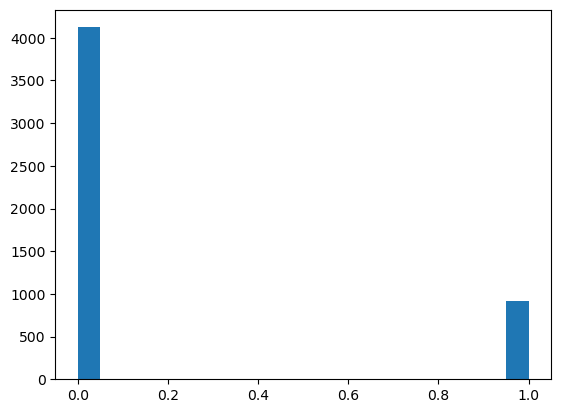

In [185]:
plt.hist(number_isolated_nodes, bins = 20)
plt.show()

### Analysing split function

In [ ]:
def get_split_index(y):
    rng = np.random.RandomState(42) #Setting seed
    N = len(y) 

    indices = np.arange(N)

    val_size = 0.1
    train_size = 0.1

    train_val_size = int(N *(val_size+train_size))

    valid_rows = ~np.isnan(y).any(axis=1)

    true_idx = np.argwhere(valid_rows)

    if train_val_size > len(true_idx):
        raise ValueError(f"Validation/test size must be smaller. Only {len(true_idx)} values available.")
    

    #Selecting index
    random_idx = rng.choice(len(true_idx),size=train_val_size, replace=False)
    random_index = true_idx[random_idx]

    train_indices = np.setdiff1d(indices,random_index)

    val_indices = random_index[0:int(N*val_size)].flatten()
    test_indices = random_index[int(N*val_size):].flatten()

    return train_indices,val_indices,test_indices


In [ ]:
num_turbines = 16
data_columns = ['ws_000', 'wd_001']

df = pd.read_parquet('/Users/lisavind/GitHub/wind_power_prediction/data/SCADA_filtered_2020-01-01__2024-12-01.parquet')


X = df[data_columns].to_numpy()
y = df[[f'pow_{str(i).zfill(3)}' for i in range(num_turbines)]].values

valid_rows = ~np.isnan(X).any(axis=1)
X = X[valid_rows]
y = y[valid_rows]

In [ ]:
train_indices,val_indices,test_indices = get_split_index(y)

In [ ]:
print(len(train_indices))

151357


In [ ]:
print(type(train_indices))

<class 'numpy.ndarray'>


In [ ]:
np.random.shuffle(train_indices)

In [ ]:
test = [0,1,2,3,4,5]

In [154]:
with open('/Users/lisavind/GitHub/wind_power_prediction/data/graphs/directed_True_simulated_True_local_False_global_True_D_136_length_2720_width_3_angle_25/index.pkl', "rb") as f:
    loaded_array = pickle.load(f)

print(loaded_array)

[array([22880, 75522,  3527, ..., 41417, 87131, 51148]), array([33207, 29804, 28723, ..., 21161, 13775, 65193]), array([55497, 57397,  2350, ..., 63567,  3460,  1396])]


In [222]:
df = pd.read_parquet('/Users/lisavind/GitHub/wind_power_prediction/data_simulated/floris_simulated_era5.parquet')

In [223]:
df.head()

,wd,ws,ti,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,...,pow_008,pow_009,pow_010,pow_011,pow_012,pow_013,pow_014,pow_015,wd_sin,wd_cos
0,254.69,8.76,0.11,2689.843,1691.157,2689.843,1426.915,2689.843,2626.169,2542.937,...,2689.817,2689.843,1254.933,1228.772,2689.843,2409.676,1594.364,2430.671,-0.964511,-0.264041
1,254.73,8.86,0.07,2771.500,1715.721,2771.500,1392.523,2771.500,2721.967,2650.218,...,2771.499,2771.500,1078.034,1155.392,2771.500,2561.522,1606.367,2556.859,-0.964695,-0.263368
2,254.76,8.95,0.09,2844.992,1770.672,2844.992,1492.042,2844.992,2787.344,2705.157,...,2844.984,2844.992,1239.461,1248.337,2844.992,2598.067,1675.960,2596.590,-0.964833,-0.262863
3,254.80,9.05,0.12,2920.304,1848.475,2920.304,1612.109,2920.304,2856.428,2759.922,...,2920.262,2920.304,1445.401,1365.385,2920.304,2623.847,1763.899,2635.992,-0.965016,-0.262189
4,254.83,9.14,0.11,2974.652,1883.014,2974.652,1646.452,2974.652,2927.060,2838.747,...,2974.629,2974.652,1450.049,1385.254,2974.652,2716.067,1801.427,2717.166,-0.965154,-0.261684


In [225]:
def inverse_transform_wind_direction(row):
    """
    Converts sine and cosine components back to wind direction in degrees.

    Parameters:
    - row (pd.Series): A row of the DataFrame containing sine and cosine values.

    Returns:
    - float: Wind direction in degrees (0 to 360).
    """
    sin_val = row['wd_sin']
    cos_val = row['wd_cos']
    radians = np.arctan2(sin_val, cos_val)
    degrees = np.rad2deg(radians)
    degrees = (degrees + 360) % 360  # Ensure degrees are in [0, 360)
    return degrees

# Apply the function row-wise
df['degrees_2'] = df.apply(inverse_transform_wind_direction, axis=1)

# Print the resulting degrees column
print(df['degrees_2'])

0        254.69
1        254.73
2        254.76
3        254.80
4        254.83
          ...  
82683    240.88
82684    240.26
82685    239.64
82686    239.01
82687    237.40
Name: degrees_2, Length: 82688, dtype: float64


In [204]:
objects = []
with (open("/Users/lisavind/GitHub/wind_power_prediction/data/graphs/directed_True_simulated_True_local_False_global_True_features_4_D_136_length_2720_width_2_angle_3/scaler_x.pk", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [207]:
objects[0].data_min_

array([ 0.41,  0.01, -1.  , -1.  ])

In [208]:
objects[0].data_max_

array([ 15.86, 360.  ,   1.  ,   1.  ])